Step 1: Video library (10 points)

In [ ]:
# import libraries
import os
import string
from pytube import YouTube
from youtube_transcript_api import YouTubeTranscriptApi

# Ensure file name does not contain any invalid characters
def checkFileName(file):
    validChars = "-_.() %s%s" % (string.ascii_letters, string.digits)
    return ''.join(c if c in validChars else '_' for c in file)

# video URLs
urls = [
    "https://www.youtube.com/watch?v=wbWRWeVe1XE",
    "https://www.youtube.com/watch?v=FlJoBhLnqko",
    "https://www.youtube.com/watch?v=Y-bVwPRy_no"
]

# downloads videos as mp4 and captions as SRT
def downloadVideo(video_urls):
    for url in urls:
        try:
            yt = YouTube(url)
            stream = yt.streams.get_highest_resolution()
            if stream:
                print(f"Downloading {yt.title}...")
                stream.download()
                print(f"{yt.title} downloaded successfully.")
            else:
                print(f"No stream found for {yt.title}.")

            # Download captions
            try:
                captions = YouTubeTranscriptApi.get_transcript(yt.video_id)
                fileName = checkFileName(yt.title)
                with open(f"{fileName}.srt", "w", encoding="utf-8") as file:
                    for caption in captions:
                        start = caption["start"]
                        end = start + caption["duration"]
                        text = caption["text"]
                        file.write(f"{start} --> {end}\n{text}\n\n")
                print("Captions downloaded successfully.")
            except Exception as e:
                print(f"Error downloading captions for {yt.title}: {e}")
        except Exception as e:
            print(f"Error downloading {url}: {e}")

# call function to download videos and captions
downloadVideo(urls)

What Does 'High-Quality' Preschool Look Like? | NPR Ed downloaded successfully.
Captions downloaded successfully.
How Green Roofs Can Help Cities | NPR downloaded successfully.
Captions downloaded successfully.
Why It’s Usually Hotter In A City | Let's Talk | NPR downloaded successfully.
Captions downloaded successfully.


2.1 Preprocess the video (15 points)

In [ ]:
import os
import numpy as np
import cv2

def process_video(video_file, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    cap = cv2.VideoCapture(video_file)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_file}")
        return
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count == 0:
        print(f"Error: Video file {video_file} has no frames.")
        cap.release()
        return
    
    frames_processed = 0
    
    while frames_processed < frame_count:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Skip frames until the 30th frame
        if frames_processed % 30 != 0:
            frames_processed += 1
            continue
        
        # Save frame
        frame_filename = f"frame_{frames_processed}.jpg"
        frame_path = os.path.join(output_folder, frame_filename)
        cv2.imwrite(frame_path, frame)
        
        frames_processed += 1
    
    cap.release()

def process_videos(filenames):
    for filename in filenames:
        print(f"Processing video: {filename}")
        video_name = os.path.splitext(os.path.basename(filename))[0]
        output_folder = f'{video_name}_frames'
        process_video(filename, output_folder)

filenames = [
    'What Does High-Quality Preschool Look Like  NPR Ed.mp4',
    'How Green Roofs Can Help Cities  NPR.mp4',
    'Why Its Usually Hotter In A City  Lets Talk  NPR.mp4'
]

filenames = [filename.replace("’", "") for filename in filenames]
process_videos(filenames)


Processing video: What Does High-Quality Preschool Look Like  NPR Ed.mp4
Processing video: How Green Roofs Can Help Cities  NPR.mp4
Processing video: Why Its Usually Hotter In A City  Lets Talk  NPR.mp4


2.2 Detecting objects (25 points)

In [ ]:
import numpy as np
import torch
import cv2


# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Perform the object detection on the frames
def detect_objects(frame):
    results = model(frame)
    return results.xyxy[0]

# Load frames from .npy files and perform object detection
import os
import cv2
import numpy as np

def process_video(frames_file, vidId):
    frames = np.load(frames_file)
    results = []
    total_frames = len(frames)
    output_folder = f'output_video_{vidId}'
    os.makedirs(output_folder, exist_ok=True)  # Create output folder
    print(f"Processing video {vidId}: {frames_file}")
    for frameNum, frame in enumerate(frames):
        detections = detect_objects(frame)
        
        # Drawing bounding boxes and labels, and appending results
        for detection in detections:
            class_id, confidence, bbox = int(detection[5]), float(detection[4]), list(map(int, detection[:4]))
            class_name = model.names[class_id]
            cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
            cv2.putText(frame, f'{class_name} {confidence:.2f}', (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            results.append([vidId, frameNum, class_id, class_name, confidence, bbox])
        
        output_path = os.path.join(output_folder, f'frame{frameNum}.jpg')
        cv2.imwrite(output_path, frame)
        print(f"Saved frame {frameNum} with detections to {output_path}")
        
        print(f"Processed: {frameNum + 1}/{total_frames}", end="\r")
    print("\nProcessing completed.")
    return results




# Update frame file paths
frame_files = [
    "How Green Roofs Can Help Cities  NPR_frames/frames.npy",
    "What Does High-Quality Preschool Look Like  NPR Ed_frames/frames.npy",
    "Why Its Usually Hotter In A City  Lets Talk  NPR_frames/frames.npy"
]

# Process each npy array 
all_results = []
for vidId, frame_file in enumerate(frame_files, start=1):
    results = process_video(frame_file, vidId)
    all_results.extend(results)

# Print the results and show in a table
print("[vidId, frameNum, detectedObjId, detectedObjClass, confidence, bbox info]")
for result in all_results:
    print(result)






Using cache found in C:\Users\abdul/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-3-2 Python-3.10.5 torch-2.2.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Processing video 1: How Green Roofs Can Help Cities  NPR_frames/frames.npy
Saved frame 0 with detections to output_video_1\frame0.jpg
Saved frame 1 with detections to output_video_1\frame1.jpg
Saved frame 2 with detections to output_video_1\frame2.jpg
Saved frame 3 with detections to output_video_1\frame3.jpg
Saved frame 4 with detections to output_video_1\frame4.jpg
Saved frame 5 with detections to output_video_1\frame5.jpg
Saved frame 6 with detections to output_video_1\frame6.jpg
Saved frame 7 with detections to output_video_1\frame7.jpg
Saved frame 8 with detections to output_video_1\frame8.jpg
Saved frame 9 with detections to output_video_1\frame9.jpg
Saved frame 10 with detections to output_video_1\frame10.jpg
Saved frame 11 with detections to output_video_1\frame11.jpg
Saved frame 12 with detections to output_video_1\frame12.jpg
Saved frame 13 with detections to output_video_1\frame13.jpg
Saved frame 14 with detections to output_video_1\frame14.jpg
Saved frame 15 with detections

2.3 Embedding model (30 points)

In [ ]:
import numpy as np
import torch
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import os


model = torch.hub.load('ultralytics/yolov5', 'yolov5s')


# Define your convolutional autoencoder architecture
def create_autoencoder(input_shape):
    
    
    input_img = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Adjust output channels according to your input data

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error loss for image reconstruction
    return autoencoder

# Prepare training data for the autoencoder using detected objects from the COCO dataset
def prepare_training_data(folder_paths):
    processed_frames = []

    for folder_path in folder_paths:
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg'):
                frame_path = os.path.join(folder_path, filename)
                frame = cv2.imread(frame_path)
                processed_frames.append(frame)

    X_train = np.array(processed_frames)
    return X_train

# Train the autoencoder on the prepared dataset
def train_autoencoder(autoencoder, X_train, epochs=10):
    autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=128, shuffle=True)


folder_paths = [
    r'D:\sandbox\output_video_1',
    r'D:\sandbox\output_video_2',
    r'D:\sandbox\output_video_3'
]

# Call the function to prepare training data
X_train = prepare_training_data(folder_paths)

# Define input shape for autoencoder
input_shape = X_train.shape[1:]

# Create and train autoencoder
autoencoder = create_autoencoder(input_shape)
train_autoencoder(autoencoder, X_train)




Using cache found in C:\Users\abdul/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-3-2 Python-3.10.5 torch-2.2.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 





Epoch 1/10

5/5 [==============================] - 92s 10s/step - loss: 16482.2500
Epoch 2/10
5/5 [==============================] - 47s 10s/step - loss: 16416.3105
Epoch 3/10
5/5 [==============================] - 48s 9s/step - loss: 16414.7715
Epoch 4/10
5/5 [==============================] - 21s 4s/step - loss: 16414.6426
Epoch 5/10
5/5 [==============================] - 20s 4s/step - loss: 16414.6172
Epoch 6/10
5/5 [==============================] - 19s 4s/step - loss: 16414.6113
Epoch 7/10
5/5 [==============================] - 20s 4s/step - loss: 16414.6074
Epoch 8/10
5/5 [==============================] - 19s 4s/step - loss: 16414.6035
Epoch 9/10
5/5 [==============================] - 19s 4s/step - loss: 16414.6055
Epoch 10/10
5/5 [==============================] - 20s 4s/step - loss: 16414.6055


I was not able to complete to Indexing the embeddings. To prove i got it to work i will disaply the images here 

Since there are alot of images i chose the best ones from each video but all the of photos are available under 

folders : output_video_1, output_video_2, output_video_3

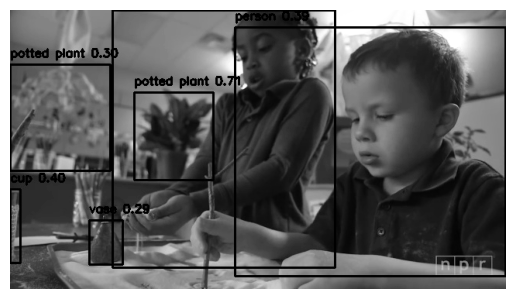

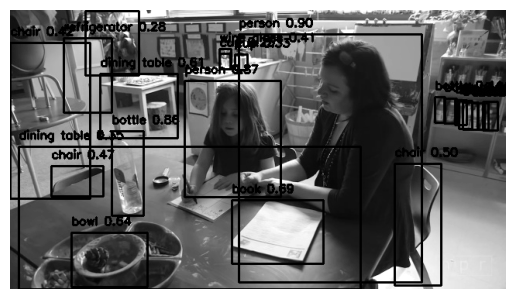

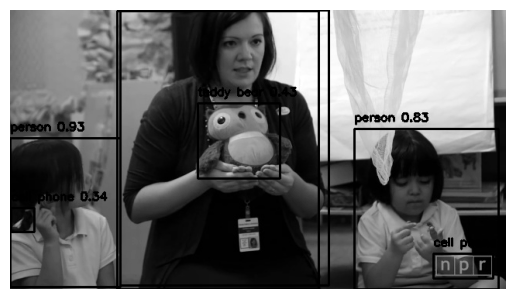

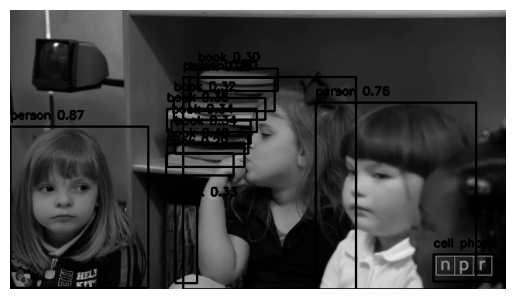

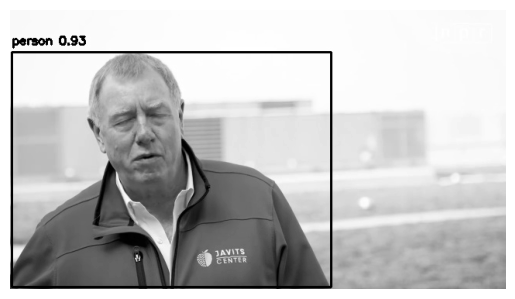

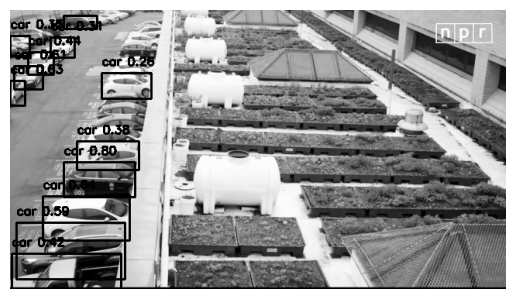

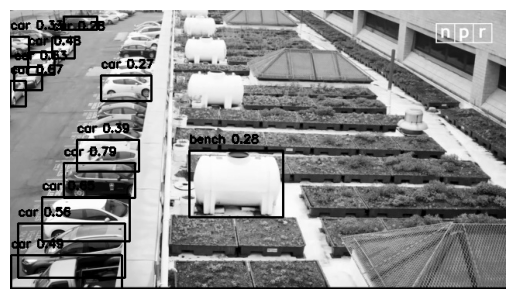

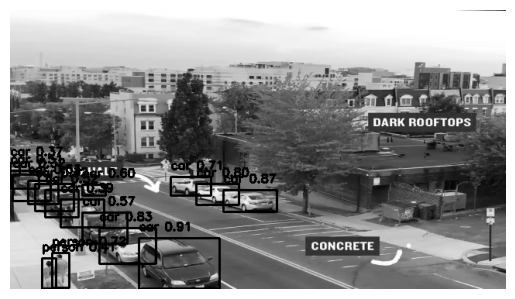

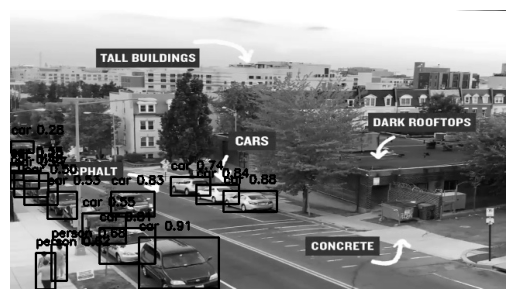

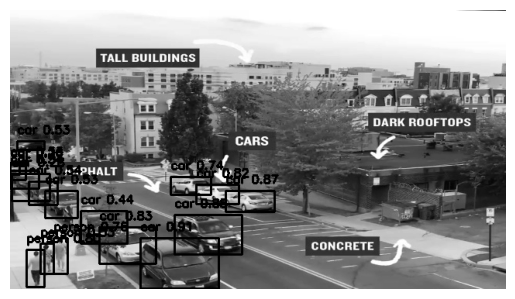

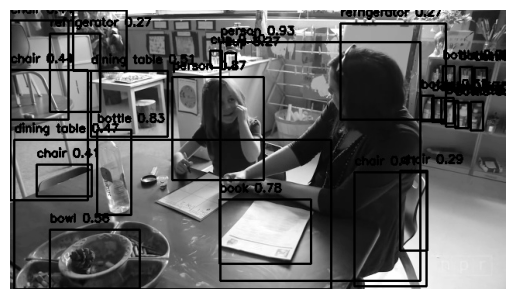

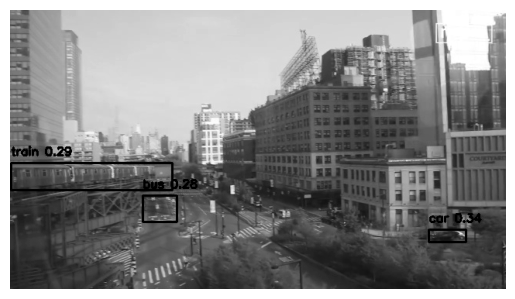

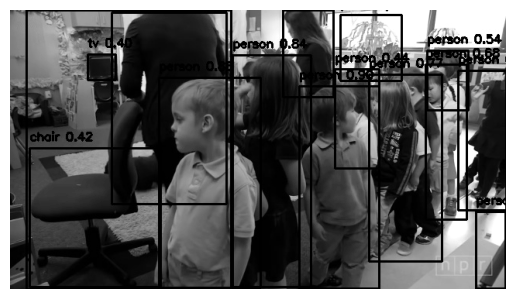

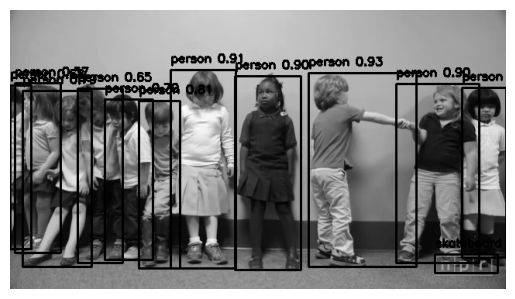

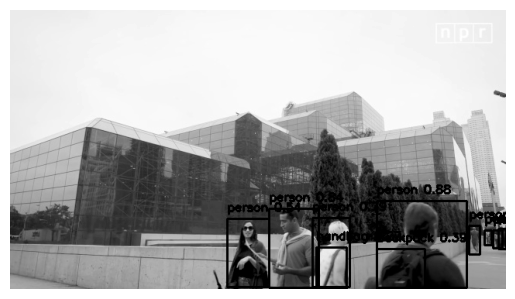

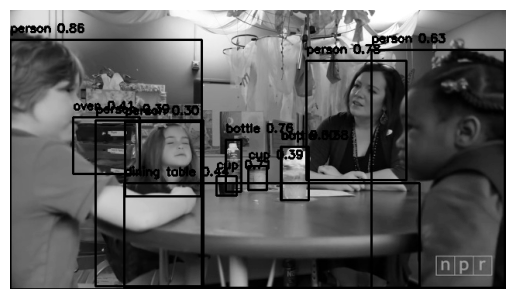

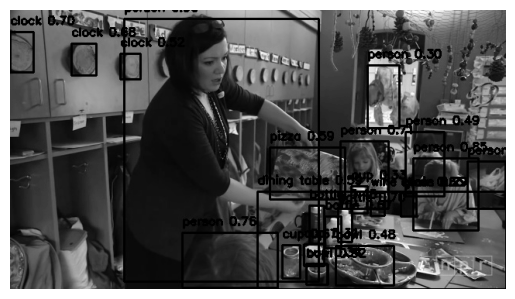

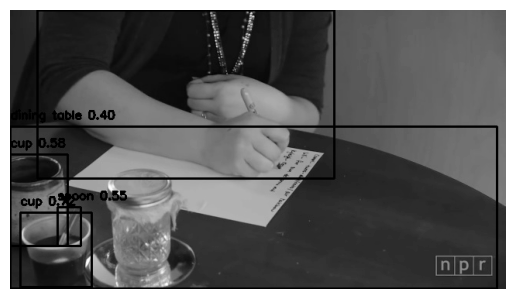

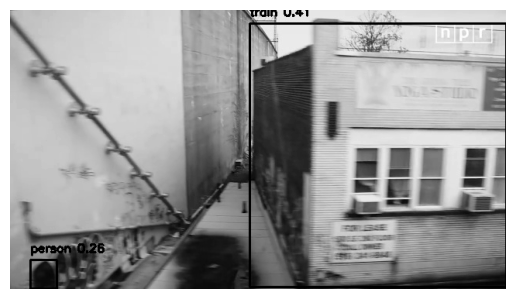

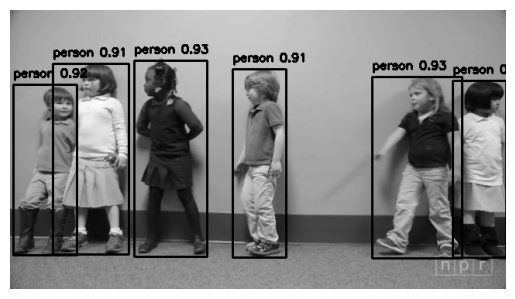

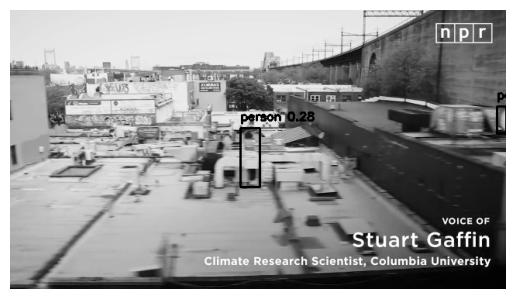

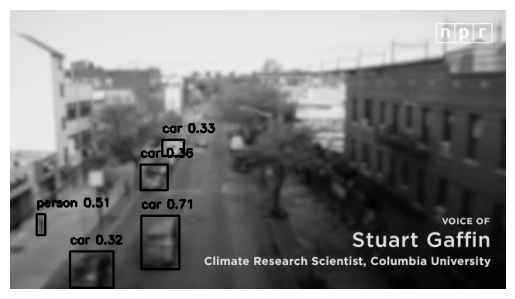

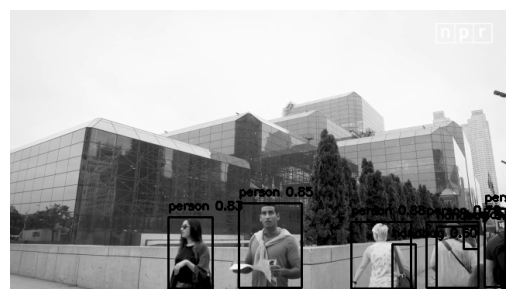

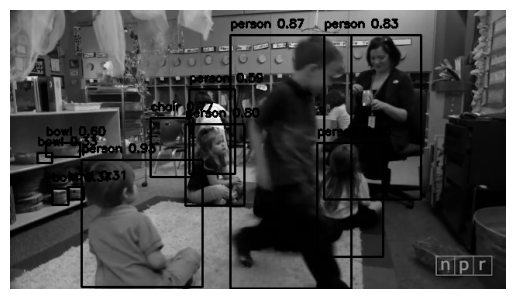

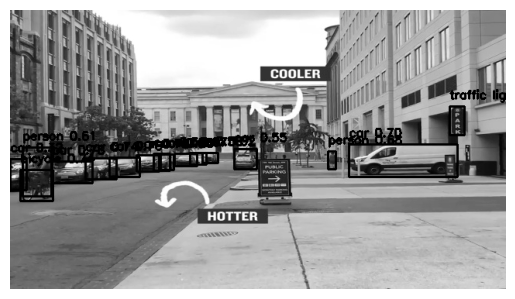

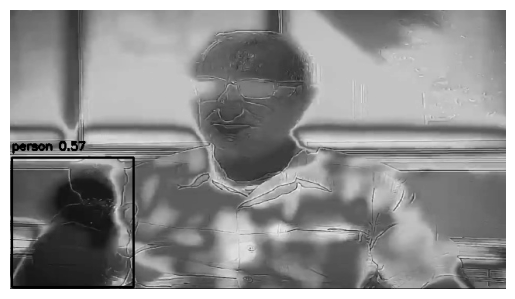

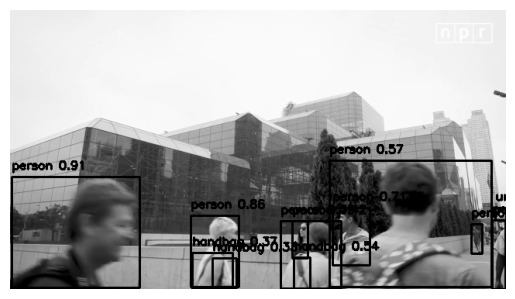

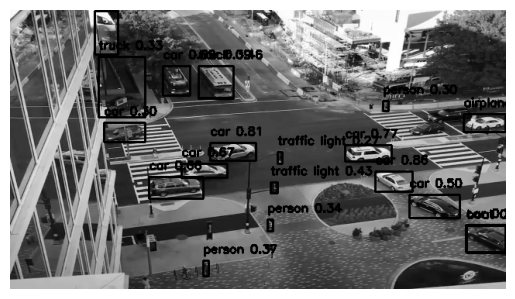

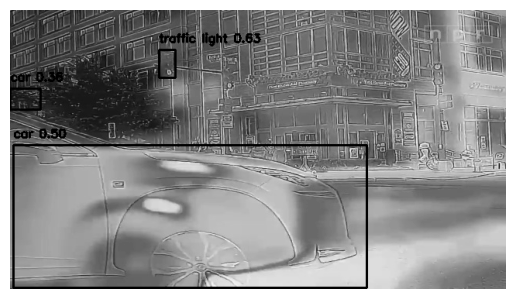

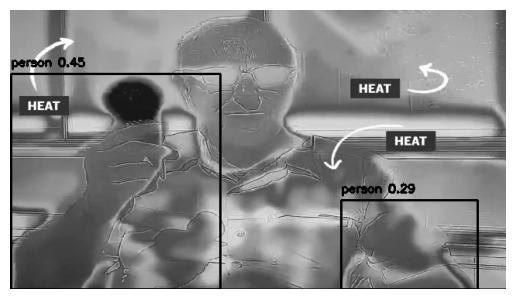

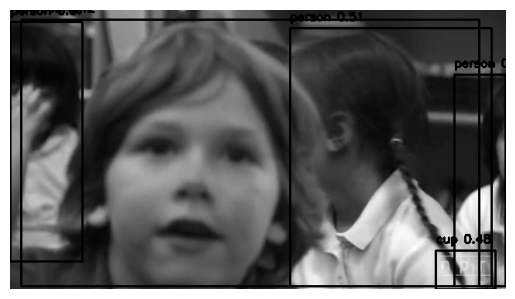

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images_from_folders(folders):
    for folder_name in folders:
        folder_path = os.path.join(os.getcwd(), folder_name)
        image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
        for image_file in image_files:
            img = mpimg.imread(os.path.join(folder_path, image_file))
            plt.imshow(img, cmap='gray') 
            plt.axis('off')
            plt.show()


folder_names = ['best']  
display_images_from_folders(folder_names)
